#### Read and Convert TalTech Sensor Data

In [99]:
from mmap import mmap, ACCESS_READ
from struct import unpack
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [128]:
def unpacking_v2_format_hig(row, conversion):
    #print(row)
    list_values = []
    index = (unpack('>I', bytes(row[0:4]))[0]) 
    acc_x = (unpack('>h', bytes(row[4:6]))[0]) * conversion
    acc_y = (unpack('>h', bytes(row[6:8]))[0])  * conversion
    acc_z = (unpack('>h', bytes(row[8:10]))[0])  * conversion

    #index = (index / 6000)
    #list_values.append(index)
    acc_x = float(acc_x) 
    list_values.append(acc_x)
    acc_y = acc_y 
    list_values.append(acc_y)
    acc_z = acc_z 
    list_values.append(acc_z)
    amag = round(sqrt(pow(acc_x, 2) + pow(acc_y, 2) + pow(acc_z, 2)),2)
    list_values.append(amag)

    return list_values

def read_row(mm, frame_length, hig=1,):
    count = 0
    while True:
        count += 1
        if(hig==1):
            row = mm.read(frame_length) # packet length
            if not len(row) == frame_length: 
                break 
        yield row 

def read_hig_file_to_df(file_path, frame_length, conversion):
    with open(file_path,'rb') as file:
        mm = mmap(file.fileno(), 0, access=ACCESS_READ)
        results = [unpacking_v2_format_hig(row, conversion) for row in read_row(mm, frame_length)]
        
        mm.close()
        file.close()
    
        # need to create a data frame
        df = pd.DataFrame(results, columns=['X', 'Y', 'Z', 'mag'])
        return df

In [129]:
#test_file_path = "../../data/raw_data/flight/exp1/taltech/shoes/sw5_B021105121250.HIG"
#test_file_path = "../../data/raw_data/flight/exp1/taltech/barefoot/bw17_B021105115947.HIG"
#test_file_path = "../../data/raw_data/flight/exp1/taltech/barefoot/bw16_B021105115649.HIG"
#test_file_path = "../../data/raw_data/flight/exp1/taltech/shoes/sw3_B021105115346.HIG"
#test_file_path = "../../data/raw_data/flight/exp1/taltech/shoes/sr7_B021105121850.HIG"
#test_file_path = "../../data/raw_data/flight/exp2/taltech/shoes/sw2_B021106135949.HIG"
#test_file_path = "../../data/raw_data/flight/exp2/taltech/shoes/sj10_B021106142948.HIG"
frame_length = 11
conversion = 0.000488
base = "../../data/raw_data"
sensor = "taltech"
o_path = "../../data/clean"

In [130]:
def write_df_to_csv(df, output_path):
    directory = os.path.dirname(output_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    df.to_csv(output_path, index=False)
    print(f"Processed data saved to {output_path}")


## read all files
env_dirs = [entry.name for entry in os.scandir(base) if entry.is_dir()]
print(env_dirs)

for env in env_dirs:
    # gets exp1 and exp2
    exp_dirs = [entry.name for entry in os.scandir(f"{base}/{env}") if entry.is_dir()]
    print(exp_dirs)
    for e in exp_dirs:
        #path for an experimenter 
        exp_path = f"{base}/{env}/{e}/{sensor}"
        # get the shoes / barefoot dirs
        fw_dirs = [entry.name for entry in os.scandir(exp_path) if entry.is_dir()]
        print(fw_dirs)
        for f in fw_dirs:
            fw_path = f"{exp_path}/{f}/*.HIG"
            print(fw_path)
            for file_path in glob.glob(fw_path):
                file_name = file_path.split("\\")[1].split("_")[0]
                # construct output path
                o = f"{o_path}/{env}/{e}/{sensor}/{f}/{file_name}.csv"
                # convert the file to df
                df = read_hig_file_to_df(file_path, frame_length, conversion)
                # trim the df to 15s
                df = df.iloc[30000:]
                df = df.iloc[:90000]
                write_df_to_csv(df, o)

['baseline', 'flight']
['exp1', 'exp2']
['barefoot', 'shoes']
../../data/raw_data/baseline/exp1/taltech/barefoot/*.HIG
../../data/raw_data/baseline/exp1/taltech/barefoot\bj24_B021101160014.HIG
Processed data saved to ../../data/clean/baseline/exp1/taltech/barefoot/bj24.csv
../../data/raw_data/baseline/exp1/taltech/barefoot\bj25_B021101160056.HIG
Processed data saved to ../../data/clean/baseline/exp1/taltech/barefoot/bj25.csv
../../data/raw_data/baseline/exp1/taltech/barefoot\bj26_B021101160136.HIG
Processed data saved to ../../data/clean/baseline/exp1/taltech/barefoot/bj26.csv
../../data/raw_data/baseline/exp1/taltech/barefoot\br20_B021101155701.HIG
Processed data saved to ../../data/clean/baseline/exp1/taltech/barefoot/br20.csv
../../data/raw_data/baseline/exp1/taltech/barefoot\br21_B021101155744.HIG
Processed data saved to ../../data/clean/baseline/exp1/taltech/barefoot/br21.csv
../../data/raw_data/baseline/exp1/taltech/barefoot\br22_B021101155832.HIG
Processed data saved to ../../da

In [131]:
# read in some data to test

base = "../../data/clean/"
env = "flight" #baseline / flight
sensor = "taltech"
exp = 2
s_p_code = 5
b_p_code = 17

activity = "w" # w r j for walk run jump

# parabola codes
s_code = f"s{activity}{str(s_p_code)}"
b_code = f"b{activity}{str(b_p_code)}"

print(s_code, b_code)

sw5 bw17


In [132]:
## read in left and right

s_data_path = f"{base}{env}/exp{exp}/{sensor}/shoes/{s_code}.csv"
b_data_path = f"{base}{env}/exp{exp}/{sensor}/barefoot/{b_code}.csv"

# data paths shoes and barefoot
s_data = pd.read_csv(s_data_path)
b_data = pd.read_csv(b_data_path)


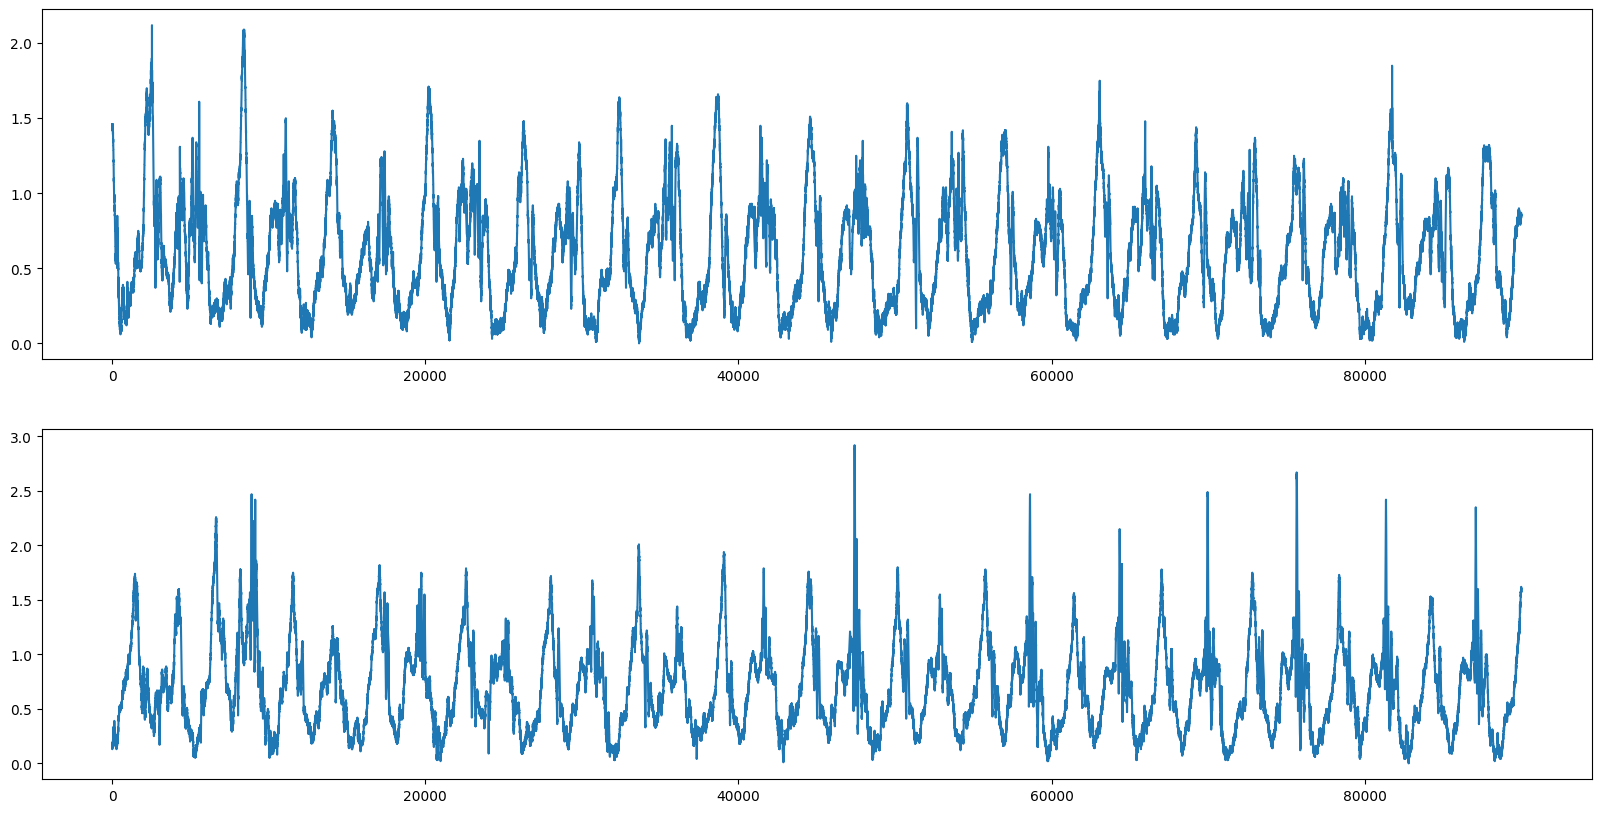

In [133]:
# plot the mag
# simple graphs
fig, ax = plt.subplots(2,1, figsize=(20, 10))

ax[0].plot(s_data["mag"])
ax[1].plot(b_data["mag"])